## Midterm 3
### Assigment 2
Author: Vojtech Orava

---------
Assigment details:

Implement your own convolutional network to solve problem of horse semantic segmentation from the background in the Horses Dataset. Choose your favourite convolutional-type architecture to solve the problem and motivate your choice. The design decisions about how many layers, the type of layers and how they are interleaved, the type of pooling, the use of residual connections, etc. are also on you.  Train and validate the model on the data as appropriate in Machine Learning an provide a measure of segmentation accuracy.

Dataset link: [www.kaggle.com/datasets/ztaihong/weizmann-horse-database/data](www.kaggle.com/datasets/ztaihong/weizmann-horse-database/data)

### Solution

For the solution of this assigment I choose to use UNET convolution neural network (https://arxiv.org/pdf/1505.04597). Structure of this model is shown in the image below.

![UNET CNN](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png "UNET")


In [1]:
# importing neccessary libraries and functions
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
! pip install -q kaggle
from google.colab import files

### Data download

Code in the cell below downloads horse dataset from kaggle (API json key is needed for this action) and extracts all images to the folder for further use.

In [2]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list
! kaggle datasets download -d 'ztaihong/weizmann-horse-database'
! mkdir weizmann-horse-db
! unzip weizmann-horse-database.zip -d weizmann-horse-db

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ztaihong/weizmann-horse-database
License(s): copyright-authors
 87% 98.0M/113M [00:00<00:00, 463MB/s]
100% 113M/113M [00:00<00:00, 403MB/s] 
Archive:  weizmann-horse-database.zip
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse001.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse002.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse003.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse004.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse005.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse006.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse007.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse008.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse009.png  
  inflating: weizmann-horse-db/weizmann_horse_db/horse/horse010.png  
  inflating: weizmann-horse-db/weizmann_ho

#### Hyperparameters
Here are hyperparameters and paths to files set. There is also defined device to be use and size of image (used for preprocessing resize).

**LOAD_MODEL** defines if previously trained model weights should be loaded from file or not.

In [3]:
LEARNING_RATE = 0.0001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 2
NUM_EPOCHS = 6
NUM_WORKERS = 1
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
PIN_MEMORY = True
IMG_DIR = "weizmann-horse-db/weizmann_horse_db/horse"
MASK_DIR = "weizmann-horse-db/weizmann_horse_db/mask"
NUMBER_OF_VALID_IMGS = 16
NUMBER_OF_TEST_IMGS = 16

LOAD_MODEL = False

### Segmentation Model

In this part, UNET model is recreated in **pytorch**. Code for the network is derived from the UNET architecture image and from the code on github (https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/model.py)

In [4]:
# this class defines convolution module which is then used in every "floor" of the UNET architecture
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [5]:
class UNET(nn.Module):
    # 3 input channels (RGB), 1 output channel
    def __init__(self, in_ch=3, out_ch=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down part UNET
        for f in features:
            self.downs.append(DoubleConv(in_ch, f))
            # we will get 64 output channels, then 128, then 256 and finally 512
            in_ch = f

        # up part UNET
        for f in reversed(features):
            # f*2 because connection between down and up parts
            # 512*2 -> 512 and so on
            self.ups.append(
                nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2)
            )

            self.ups.append(DoubleConv(f*2, f))

        # bottom part
        # 512 -> 1024
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # final part
        self.final_conv = nn.Conv2d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        # going down
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # bottom bottleneck
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        # going back up
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]

            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:], antialias=True)

            conc = torch.cat([skip_connection, x], dim=1)
            x = self.ups[i+1](conc)

        return self.final_conv(x)

### Dataset load
Dataset is loaded and divided to training, validation and testing parts in this section.
Parameters **NUMBER_OF_VALID_IMGS** and **NUMBER_OF_TEST_IMGS** defines how many images will be used for validation and tests.
I decided to use 16 validation images and also 16 testing images. All other images are meant as training ones.

In [6]:
class HorseDataset(Dataset):
    def __init__(self, images_dir, mask_dir, transform = None, img_type = "train"):
        self.images_dir = images_dir
        self.mask_dir = mask_dir
        self.transform = transform
        if img_type == "train":
            self.images = os.listdir(self.images_dir)[:-NUMBER_OF_VALID_IMGS-NUMBER_OF_TEST_IMGS]
            self.masks = os.listdir(self.mask_dir)[:-NUMBER_OF_VALID_IMGS-NUMBER_OF_TEST_IMGS]
        elif img_type == "valid":
            # last 32 to 16 imgs used for validation
            self.images = os.listdir(self.images_dir)[-NUMBER_OF_VALID_IMGS-NUMBER_OF_TEST_IMGS:-NUMBER_OF_TEST_IMGS]
            self.masks = os.listdir(self.mask_dir)[-NUMBER_OF_VALID_IMGS-NUMBER_OF_TEST_IMGS:-NUMBER_OF_TEST_IMGS]
        else:
            # last 16 images used for testing
            self.images = os.listdir(self.images_dir)[-NUMBER_OF_TEST_IMGS:]
            self.masks = os.listdir(self.mask_dir)[-NUMBER_OF_TEST_IMGS:]


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
       # image = image/255

        mask_path = os.path.join(self.mask_dir, self.masks[index])
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

### Train and accuracy functions

Train and accuracy functions are defined in the cells below. Train function is called inside training loop. It tracks losses of the network for every batch.

Acuracy function calculates accuracy on validation dataset and saves accuracy values for every epoch. For accuracy calculation, accuracy_score function is used.

In [7]:
def train(model, train_loader, optimizer, criterion):

    loop = tqdm(train_loader)
    losses = []
    for batch, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        predictions = model(data)

        #print(predictions.shape, targets.shape)
        loss = criterion(predictions, targets)

        losses.append([batch, loss.item()])

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    return losses

In [13]:
def calculate_accuracy(loader, model, device="cuda"):

    model.eval()

    true_masks = []
    predicted_masks = []

    with torch.no_grad():
        for x, y in loader:
            #print(x.shape, y.shape)
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            true_masks.append(y.cpu().numpy())
            predicted_masks.append(preds.cpu().numpy())


    true_masks_flat = np.concatenate([mask.flatten() for mask in true_masks])
    predicted_masks_flat = np.concatenate([mask.flatten() for mask in predicted_masks])

    true_masks_binary = (true_masks_flat > 0).astype(int)
    predicted_masks_binary = (predicted_masks_flat > 0).astype(int)

    accuracy = accuracy_score(true_masks_binary, predicted_masks_binary)

    model.train()

    return accuracy

### Main program

Here is the main part of the program. Model is created, optimizer and loss function are set. Then all the necessary transformations on input images are performed (conversion to tensor and resize based on **IMAGE_HEIGHT** and **IMAGE_WIDTH**).

In [9]:
model = UNET(in_ch=3, out_ch=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH), antialias=True)])

train_dataset = HorseDataset(IMG_DIR, MASK_DIR, transform=transform, img_type="train")
val_dataset = HorseDataset(IMG_DIR, MASK_DIR, transform=transform, img_type="valid")
test_dataset = HorseDataset(IMG_DIR, MASK_DIR, transform=transform, img_type="test")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


In [11]:
# check if data point is correctly shaped
e = iter(test_loader)
q, t = next(e)
print(q.shape, t.shape)

torch.Size([2, 3, 300, 300]) torch.Size([2, 1, 300, 300])


Training loop trains model (which could be loaded before from the file *segmentation_model.pth*) in defined number of EPOCHs.

In [14]:
accuracies = []
losses = []

if LOAD_MODEL:
    model.load_state_dict(torch.load("segmentation_model.pth")["state_dict"])


    acc = calculate_accuracy(val_loader, model, device=DEVICE)
    print("Accuracy at start:", acc)
    accuracies.append(acc)


for epoch in range(NUM_EPOCHS):
    losses.append(train(model, train_loader, optimizer, criterion))

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    #save checkpoint
    torch.save(checkpoint, "segmentation_model.pth")

    acc = calculate_accuracy(val_loader, model, device=DEVICE)
    accuracies.append(acc)
    print(f"Accuracy at epoch {epoch + 1}: {acc}")


100%|██████████| 148/148 [00:28<00:00,  5.23it/s, loss=0.425]


Accuracy at epoch 1: 0.9029569444444444


100%|██████████| 148/148 [00:30<00:00,  4.86it/s, loss=0.223]


Accuracy at epoch 2: 0.9310680555555556


100%|██████████| 148/148 [00:30<00:00,  4.79it/s, loss=0.163]


Accuracy at epoch 3: 0.9470993055555555


100%|██████████| 148/148 [00:31<00:00,  4.64it/s, loss=0.13]


Accuracy at epoch 4: 0.9512076388888889


100%|██████████| 148/148 [00:32<00:00,  4.51it/s, loss=0.116]


Accuracy at epoch 5: 0.9508875


100%|██████████| 148/148 [00:31<00:00,  4.67it/s, loss=0.0969]


Accuracy at epoch 6: 0.9546083333333333


### Loss and accuracy

Loss and accuracy are two most important metrics when dealing with neural networks. You can see their graphs below. Loss was counted for every batch, accuracy for every epoch.

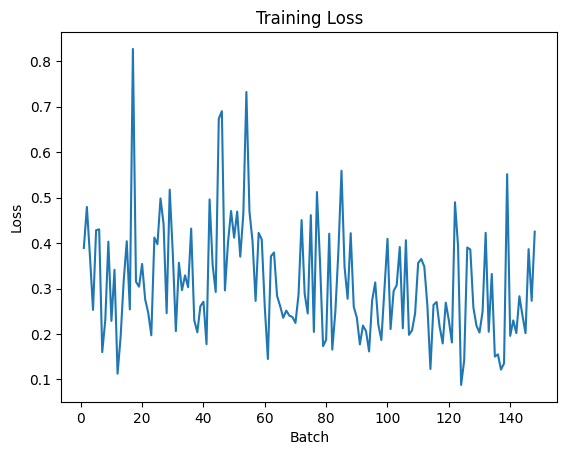

Minimal loss:  0.0


In [15]:
#plot losses
if losses:
  losses = np.array(losses)
  x = np.linspace(1,len(losses[:,:,1][0]),len(losses[:,:,1][0]), dtype=np.int32)
  plt.plot(x, losses[:,:,1][0])
  plt.xlabel("Batch")
  plt.ylabel("Loss")
  plt.title("Training Loss")
  plt.show()

  print("Minimal loss: ", np.min(losses))

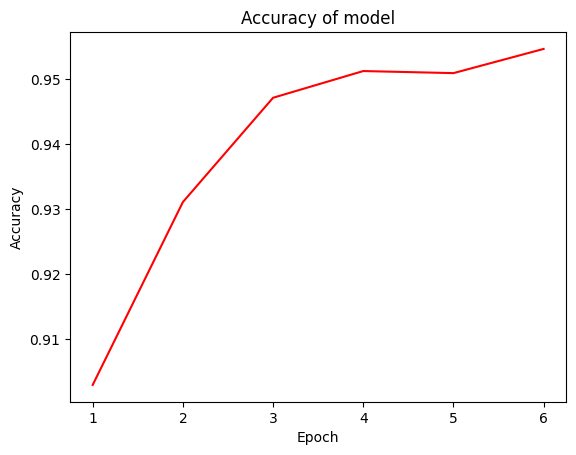

Maximum accuracy:  0.9546083333333333


In [16]:
# plot accuracy
if accuracies:
  accuracies = np.array(accuracies)
  x = np.linspace(1,len(accuracies),len(accuracies), dtype=np.int32)
  plt.plot(x, accuracies, color="red")
  plt.xticks(range(1, max(x) + 1))
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy of model")
  plt.show()

  print("Maximum accuracy: ", np.max(accuracies))

### Testing on testing images

We have 16 testing images, on which segmentation will be performed and results will be displayed below. Red mask in original image represents detected segmentation.

In [17]:
# loading images and running them through the model for inference
images_process = []
masks_process = []

for img, mask in test_loader:
    images_process.append(img)
    img = img.to(device=DEVICE)
    # detection (segmentation)
    with torch.no_grad():
        preds = torch.sigmoid(model(img))
        preds = (preds > 0.5).float()

    masks_process.append(preds)

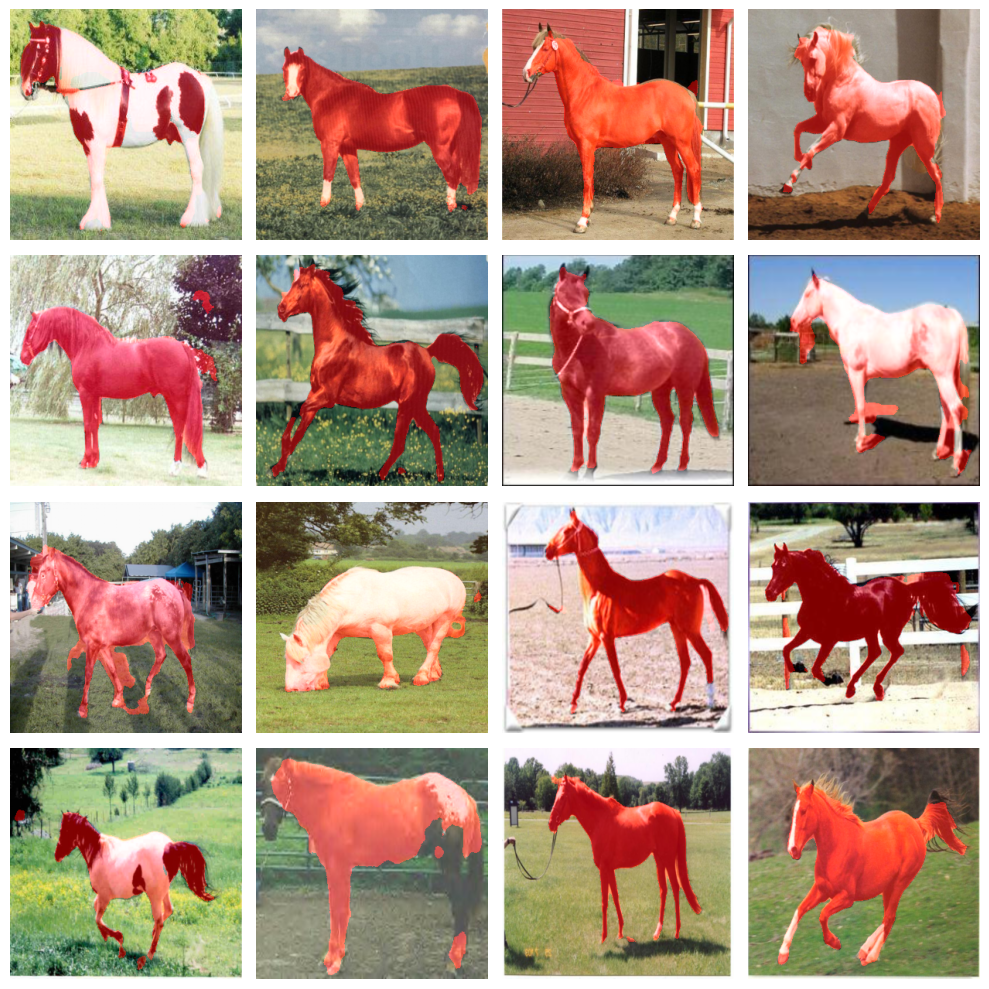

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

images_plot = []
masks_plot = []

for x,y in zip(images_process, masks_process):
  for b in range(BATCH_SIZE):
    images_plot.append(x[b])
    masks_plot.append(y[b])


for ax, image, mask_image in zip(axes.flatten(), images_plot, masks_plot):
    image = image.numpy()
    mask_image = mask_image.cpu().numpy()

    image = np.transpose(image, (1, 2, 0))
    mask_image = np.transpose(mask_image, (1,2,0))

    overlay = np.zeros_like(image)
    alpha = 0.5
    overlay[mask_image[:,:,0] > 0] = [1 * alpha, 0, 0]
    ax.imshow(image + overlay)


    ax.axis("off")

plt.tight_layout()
plt.show()

### Summary

In the end we can say that model has almost 94 % accuracy. In the last epoch the accuracy got decreased a little bit, but model still provides good results. Observing images in the last test section we can see that in most cases, horse detection is performed really well. Model could be further improved with more training, training with more data (could be created with data augmentation) or by editing hyperparameters (for example learning rate).

Thanks to pytorch variability, saved model can be loaded any time in many different applications and could be reused.